In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import shapiro
from statsmodels.formula.api import ols


## Load data and transform 

In [2]:
df_raw = pd.read_csv('data/anova/Supabase Snippet Retrieve Valid Session Allocations (4).csv')
df = df_raw.drop(['trial_sequence_id', 'session_id'], axis=1)
df[['evaluation_horizon', 'model_condition']] = df['scenario_name'].str.split('_', expand=True)
df = df.drop('scenario_name', axis=1)

df

,allocation_fund_a,evaluation_horizon,model_condition
0,30,long-term,balanced
1,10,long-term,unbalanced
2,50,short-term,balanced
3,50,short-term,unbalanced
4,0,long-term,balanced
...,...,...,...
73,10,short-term,unbalanced
74,0,long-term,balanced
75,30,long-term,unbalanced
76,50,short-term,balanced


## Data Summary

In [3]:
summary = df.groupby(['evaluation_horizon', 'model_condition'])['allocation_fund_a'].agg(['size', 'mean', 'std']).rename(columns={'size':'count'}).reset_index()
summary['se'] = summary['std'] / np.sqrt(summary['count'])

summary


,evaluation_horizon,model_condition,count,mean,std,se
0,long-term,balanced,19,45.842105,23.807709,5.461863
1,long-term,unbalanced,20,49.750000,19.431052,4.344915
2,short-term,balanced,20,38.800000,25.266162,5.649686
3,short-term,unbalanced,19,45.157895,25.364593,5.819037


## Distribution analysis

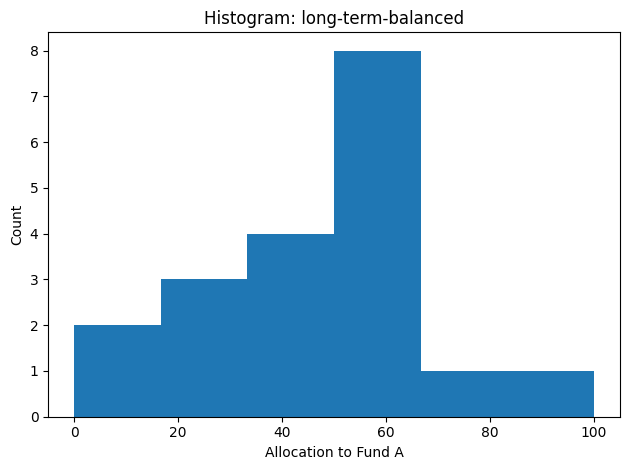

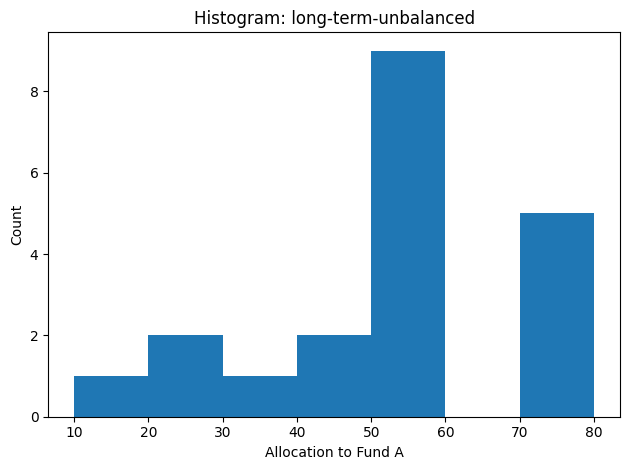

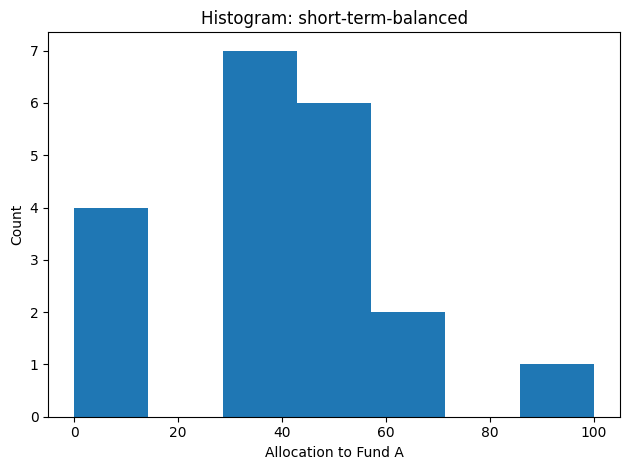

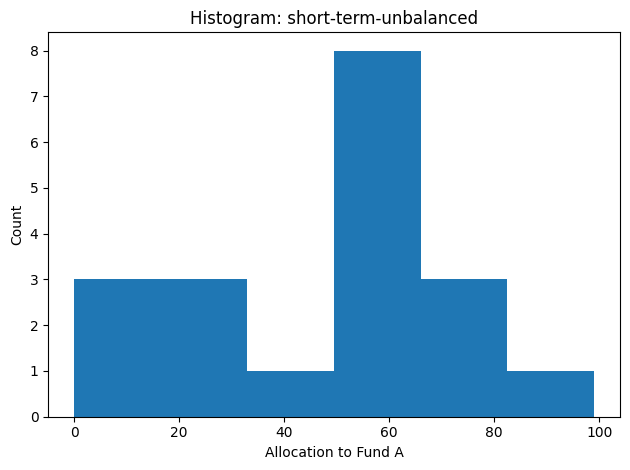

In [4]:
for (p1, p2), group in df.groupby(['evaluation_horizon', 'model_condition']):
    plt.figure()
    plt.hist(group['allocation_fund_a'], bins='auto')
    plt.xlabel('Allocation to Fund A')
    plt.ylabel('Count')
    plt.title(f'Histogram: {p1}-{p2}')
    plt.tight_layout()
    plt.show()

## Box Plot

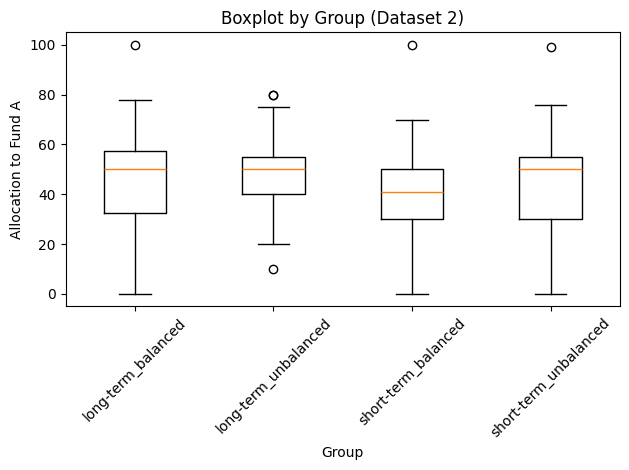

In [5]:
grouped = df.groupby(['evaluation_horizon','model_condition'])['allocation_fund_a'].apply(list)
labels = [f"{i[0]}_{i[1]}" for i in grouped.index]
plt.figure(); plt.boxplot(grouped.values); plt.xticks(range(1,len(labels)+1), labels, rotation=45)
plt.xlabel('Group'); plt.ylabel('Allocation to Fund A'); plt.title('Boxplot by Group (Dataset 2)'); plt.tight_layout(); plt.show()

## Levene

Homogeneity of variances: The variances of your outcome should be roughly equal across all groups.

In [6]:
from scipy.stats import levene

# 1) build a list of arrays, one per cell
groups = []
for level1 in df['evaluation_horizon'].unique():
    for level2 in df['model_condition'].unique():
        mask = (df['evaluation_horizon'] == level1) & (df['model_condition'] == level2)
        groups.append(df.loc[mask, 'allocation_fund_a'].values)

# 2) run Levene’s test
stat, pvalue = levene(*groups, center='mean')   # or center='median' for Brown–Forsythe
print(f"Levene’s W = {stat:.3f}, p = {pvalue:.3f}")


Levene’s W = 0.535, p = 0.660


if p ≥ .05 → no evidence of unequal variances

## Shapiro–Wilk adn QQ-Plot

Normality of residuals: Within each group, the distribution of residuald should be approximately normal.

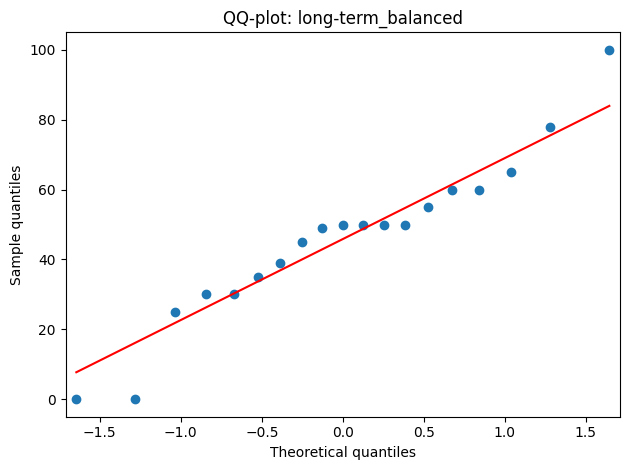

long-term_balanced Shapiro–Wilk: W=0.952, p=0.426


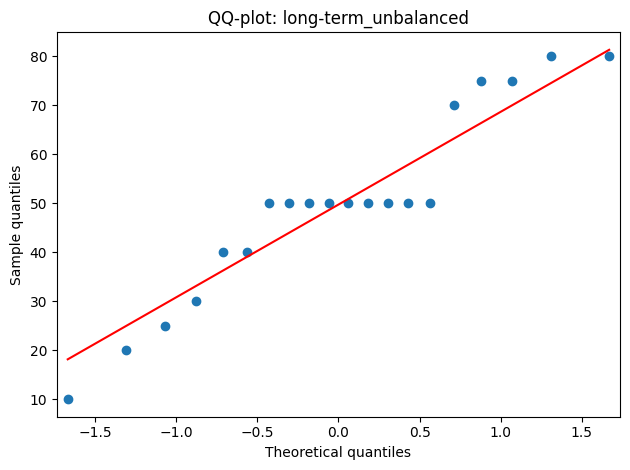

long-term_unbalanced Shapiro–Wilk: W=0.914, p=0.077


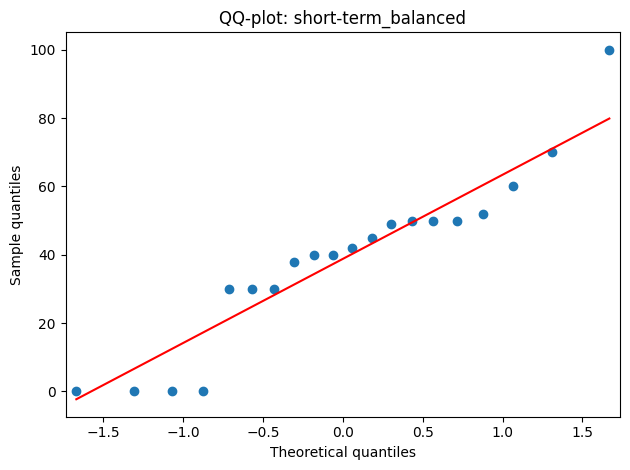

short-term_balanced Shapiro–Wilk: W=0.911, p=0.067


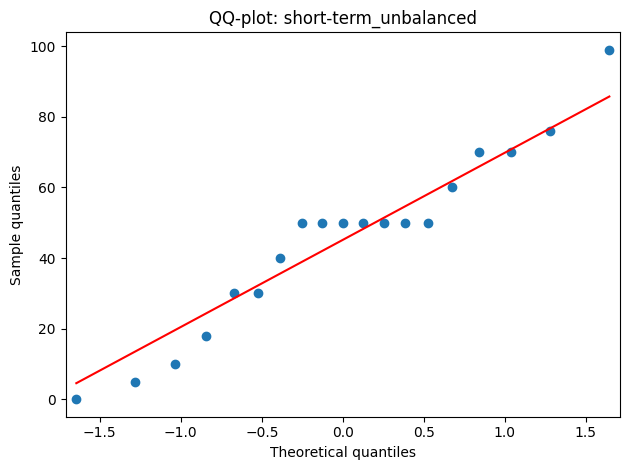

short-term_unbalanced Shapiro–Wilk: W=0.952, p=0.428


In [7]:
for (p1, p2), grp in df.groupby(['evaluation_horizon','model_condition']):
    plt.figure()
    sm.qqplot(grp['allocation_fund_a'], line='s', ax=plt.gca())
    plt.title(f'QQ‑plot: {p1}_{p2}')
    plt.xlabel('Theoretical quantiles')
    plt.ylabel('Sample quantiles')
    plt.tight_layout()
    plt.show()
    
    W, pval = shapiro(grp['allocation_fund_a'])
    print(f'{p1}_{p2} Shapiro–Wilk: W={W:.3f}, p={pval:.3f}')

if p ≥ .05 → no evidence to say the residuals (or within-group data) deviate from normality

## ANOVA

In [9]:
model = ols('allocation_fund_a ~ C(evaluation_horizon) * C(model_condition)', data=df).fit()
anova = sm.stats.anova_lm(model, typ=2)

anova


,sum_sq,df,F,PR(>F)
C(evaluation_horizon),659.421086,1.0,1.187683,0.279334
C(model_condition),513.421086,1.0,0.924723,0.339370
C(evaluation_horizon):C(model_condition),29.242949,1.0,0.052669,0.819115
Residual,41086.002632,74.0,NaN,NaN


## Interaction Plot

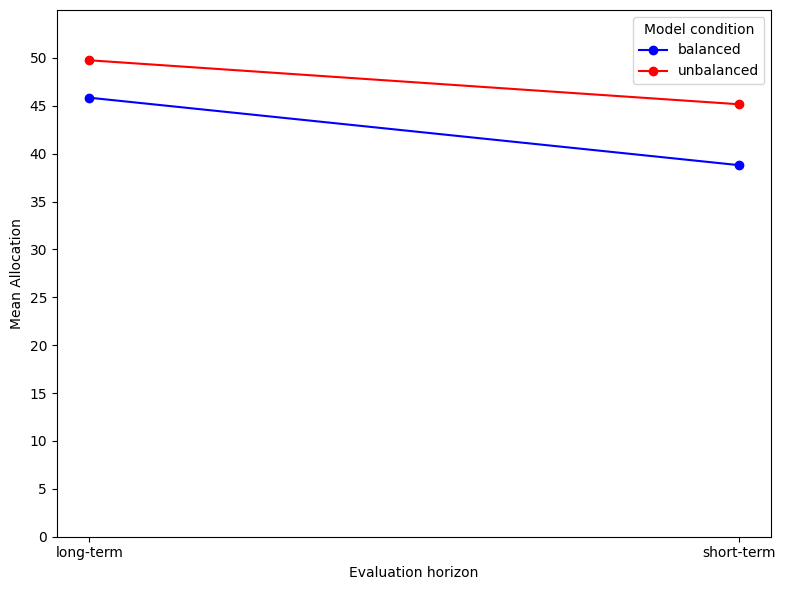

In [10]:
import numpy as np
import matplotlib.pyplot as plt

means = df.groupby(['evaluation_horizon','model_condition'])['allocation_fund_a'].mean().unstack('model_condition')

plt.figure(figsize=(8,6))

# define your two colors
colors = ['blue', 'red']

# plot, zipping together the column names and your color list
for lvl, col in zip(means.columns, colors):
    plt.plot(
        means.index, means[lvl],
        marker='o',
        color=col,
        label=lvl
    )

plt.xlabel('Evaluation horizon')
plt.ylabel('Mean Allocation')

plt.ylim(0, 55)
plt.yticks(np.arange(0, 51, 5))

plt.legend(title='Model condition')
plt.tight_layout()
plt.show()

